**" RiceLeaf Disease Detection "**

**Problem Statement :**
The objective of this project is to develop a deep learning model that can accurately classify rice leaf diseases into three categories — Leaf Smut, Brown Spot, and Bacterial Leaf Blight — using image data. This helps in early detection and better crop management.

**1. Import Required Libraries**

In [1]:
# If using Colab, install required packages (if not already installed)
!pip install tensorflow
!pip install matplotlib
# Install required packages (only if not already installed)
!pip install -q tensorflow matplotlib scikit-learn pillow


In [2]:
# Import libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import classification_report, confusion_matrix


**2. Load and Prepare the Dataset**

In [3]:
from google.colab import files
import zipfile
import os

# 1️⃣ Upload the three ZIP files
print("Please upload: BacterialBlight.zip, BrownSpot.zip, LeafSmut.zip")
uploaded = files.upload()

# 2️⃣ Create dataset folder and unzip files
dataset_dir = "rice_leaf_dataset"
os.makedirs(dataset_dir, exist_ok=True)

for zip_name in uploaded.keys():  # Loop over uploaded files dynamically
    label = zip_name.replace(".zip", "")
    path = os.path.join(dataset_dir, label)
    os.makedirs(path, exist_ok=True)

    # Extract the zip file
    with zipfile.ZipFile(zip_name, 'r') as zip_ref:
        zip_ref.extractall(path)

print("All files extracted successfully!")


Please upload: BacterialBlight.zip, BrownSpot.zip, LeafSmut.zip


Saving BacterialBlight.zip to BacterialBlight (1).zip
Saving BrownSpot.zip to BrownSpot (1).zip
Saving LeafSmut.zip to LeafSmut (1).zip
All files extracted successfully!


In [8]:
import shutil
import os

dataset_dir = "rice_leaf_dataset"

# List all folders
for folder in os.listdir(dataset_dir):
    # Skip main disease folders
    if folder not in ["BacterialBlight", "BrownSpot", "LeafSmut"]:
        path = os.path.join(dataset_dir, folder)
        shutil.rmtree(path)
        print(f"Deleted extra folder: {folder}")

    # Remove duplicates like "(1)"
    if "(1)" in folder:
        path = os.path.join(dataset_dir, folder)
        shutil.rmtree(path)
        print(f"Deleted duplicate folder: {folder}")


**3. Exploratory Data Analysis (EDA)**

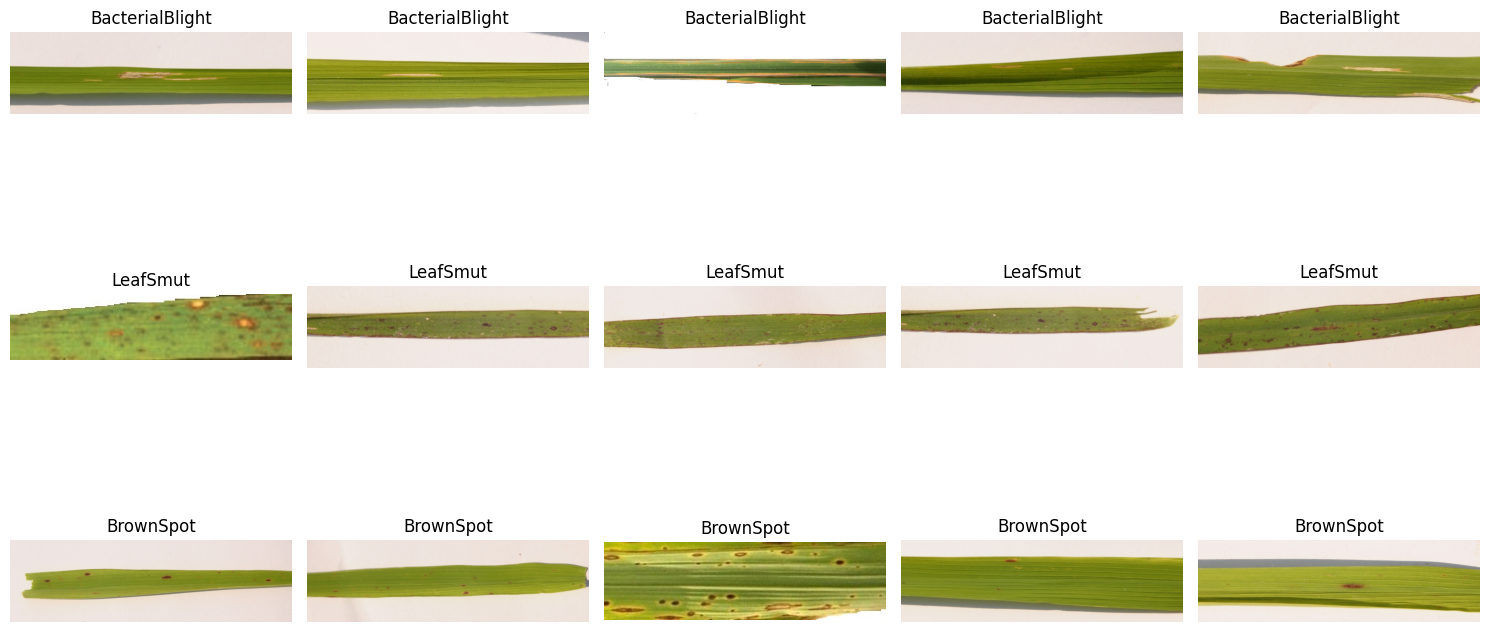

In [9]:
import matplotlib.pyplot as plt
import cv2
import os
import glob

# Path to the dataset
dataset_dir = 'rice_leaf_dataset'

# List all disease folders
diseases = os.listdir(dataset_dir)

# Number of samples per disease to display
num_samples = 5

# Calculate figure size dynamically
plt.figure(figsize=(num_samples * 3, len(diseases) * 3))

# Loop over diseases and display sample images
for row, disease in enumerate(diseases):
    disease_path = os.path.join(dataset_dir, disease)

    # Recursively get all image files (jpg, png)
    sample_images = glob.glob(os.path.join(disease_path, '**', '*.*'), recursive=True)[:num_samples]

    for col, img_path in enumerate(sample_images):
        img = cv2.imread(img_path)

        if img is None:
            print(f"Could not read image: {img_path}")
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(len(diseases), num_samples, row * num_samples + col + 1)
        plt.imshow(img)
        plt.title(disease)
        plt.axis('off')

plt.tight_layout()
plt.show()


**4. Data Augmentation and Image Generators**

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image size and batch
img_height, img_width = 224, 224  # MobileNetV2 expects 224x224
batch_size = 32

# Data augmentation and rescaling
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 20% validation
)

# Training generator
train_generator = train_datagen.flow_from_directory(
    'rice_leaf_dataset',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Validation generator
val_generator = train_datagen.flow_from_directory(
    'rice_leaf_dataset',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Optional: print class indices for reference
print("Class indices:", train_generator.class_indices)


Found 96 images belonging to 3 classes.
Found 23 images belonging to 3 classes.
Class indices: {'BacterialBlight': 0, 'BrownSpot': 1, 'LeafSmut': 2}


**5. Define the CNN Model Architecture**

In [11]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# 1️⃣ Base model with pretrained weights
base_model = MobileNetV2(weights='imagenet', include_top=False,
                         input_shape=(224, 224, 3))
base_model.trainable = False  # freeze base model initially

# 2️⃣ Custom classification layers
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.4),          # increased dropout to reduce overfitting
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')   # 3 classes
])

# 3️⃣ Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 4️⃣ Callbacks to prevent overfitting and adjust learning rate
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_accuracy', save_best_only=True)

callbacks = [early_stop, reduce_lr, checkpoint]

# Optional: show model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,339 (9.24 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

**6. Train the Model**

In [12]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

class_weights = dict(enumerate(class_weights))
print(class_weights)

# Train the model using the callbacks already defined
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=callbacks  # use the previously defined callbacks
)


{0: np.float64(1.0), 1: np.float64(1.0), 2: np.float64(1.0)}


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3142 - loss: 1.6546

3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step - accuracy: 0.3112 - loss: 1.6653 - val_accuracy: 0.3913 - val_loss: 1.1278 - learning_rate: 1.0000e-04
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3299 - loss: 1.4604

3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.3385 - loss: 1.4622 - val_accuracy: 0.4783 - val_loss: 1.1894 - learning_rate: 1.0000e-04
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2847 - loss: 1.5257

3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/step - accuracy: 0.2943 - loss: 1.5095 - val_accuracy: 0.5217 - val_loss: 1.0348 - learning_rate: 1.0000e-04
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.4232 - loss: 1.3735 - val_accuracy: 0.5217 - val_loss: 1.1319 - learning_rate: 1.0000e-04
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.4180 - loss: 1.3461 - val_accuracy: 0.4783 - val_loss: 0.9263 - learning_rate: 1.0000e-04
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.4023 - loss: 1.2906 - val_accuracy: 0.4783 - val_loss: 1.0504 - learning_rate: 1.0000e-04
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 4s/step - accuracy: 0.5091 - loss: 1.0898 - val_accuracy: 0.5217 - val_loss: 1.0016 - learning_rate: 1.0000e-04
Epoch 8/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5538 - loss: 1.0017

3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.5456 - loss: 1.0271 - val_accuracy: 0.6522 - val_loss: 0.8464 - learning_rate: 1.0000e-04
Epoch 9/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.5365 - loss: 1.0205 - val_accuracy: 0.6087 - val_loss: 0.8404 - learning_rate: 1.0000e-04
Epoch 10/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5017 - loss: 0.9947

3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.4987 - loss: 1.0116 - val_accuracy: 0.7826 - val_loss: 0.6962 - learning_rate: 1.0000e-04
Epoch 11/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.5339 - loss: 0.9892 - val_accuracy: 0.6957 - val_loss: 0.7810 - learning_rate: 1.0000e-04
Epoch 12/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.6172 - loss: 0.9024 - val_accuracy: 0.5652 - val_loss: 0.8319 - learning_rate: 1.0000e-04
Epoch 13/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.5599 - loss: 1.0745 - val_accuracy: 0.6522 - val_loss: 0.6713 - learning_rate: 1.0000e-04
Epoch 14/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.5951 - loss: 0.8510 - val_accuracy: 0.7826 - val_loss: 0.6224 - learning_rate: 1.0000e-04
Epoch 15/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.6198 - loss: 0.7888 - val_accuracy: 0.7391 - val_loss: 0.6735 - learning_rate: 1.0000e-04
Epoch 16/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.6276 - loss: 0.9639 - val_accuracy:

3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.5651 - loss: 0.8762 - val_accuracy: 0.8261 - val_loss: 0.4867 - learning_rate: 1.0000e-04
Epoch 20/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6250 - loss: 0.8860

3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/step - accuracy: 0.6172 - loss: 0.8923 - val_accuracy: 0.8696 - val_loss: 0.5617 - learning_rate: 1.0000e-04
Epoch 21/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.6237 - loss: 0.7907 - val_accuracy: 0.8696 - val_loss: 0.5039 - learning_rate: 1.0000e-04
Epoch 22/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7274 - loss: 0.7016

3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.7122 - loss: 0.7129 - val_accuracy: 0.9565 - val_loss: 0.5368 - learning_rate: 1.0000e-04
Epoch 23/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6094 - loss: 0.9328

3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.6055 - loss: 0.9353 - val_accuracy: 1.0000 - val_loss: 0.3660 - learning_rate: 1.0000e-04
Epoch 24/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.6107 - loss: 0.7275 - val_accuracy: 0.9130 - val_loss: 0.4659 - learning_rate: 1.0000e-04
Epoch 25/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.6719 - loss: 0.7461 - val_accuracy: 0.8261 - val_loss: 0.4947 - learning_rate: 1.0000e-04
Epoch 26/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.5612 - loss: 0.7698 - val_accuracy: 0.9130 - val_loss: 0.4178 - learning_rate: 1.0000e-04
Epoch 27/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.7279 - loss: 0.6925 - val_accuracy: 0.6522 - val_loss: 0.6721 - learning_rate: 1.0000e-04
Epoch 28/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.6263 - loss: 0.7738 - val_accuracy: 0.7826 - val_loss: 0.5200 - learning_rate: 1.0000e-04
Epoch 29/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.6888 - loss: 0.7581 - val_accuracy:

**7. Evaluate Model Performance**

In [13]:
loss, acc = model.evaluate(val_generator)
print(f"Validation Accuracy: {acc*100:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7391 - loss: 0.6342
Validation Accuracy: 73.91%


In [14]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Reset validation generator to ensure consistent order
val_generator.reset()

# Ground truth labels
y_true = val_generator.classes

# Model predictions (deterministic if shuffle=False)
y_pred_probs = model.predict(
    val_generator,
    steps=len(val_generator),
    verbose=1
)

# Convert probabilities to class indices
y_pred = np.argmax(y_pred_probs, axis=1)

# ============================
# Evaluation Metrics
# ============================

# Test Accuracy
test_acc = np.mean(y_true == y_pred) * 100
print(f"\nTest Accuracy: {test_acc:.2f}%\n")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
labels = list(val_generator.class_indices.keys())

print("Confusion Matrix (raw):")
print(cm)

# Pretty Confusion Matrix with labels
print("\nConfusion Matrix (with labels):")
print(" " * 15 + " ".join(f"{label:15}" for label in labels))
for i, row in enumerate(cm):
    print(f"{labels[i]:15}" + " ".join(f"{num:15}" for num in row))

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=labels))


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

Test Accuracy: 82.61%

Confusion Matrix (raw):
[[8 0 0]
 [0 5 3]
 [1 0 6]]

Confusion Matrix (with labels):
               BacterialBlight BrownSpot       LeafSmut       
BacterialBlight              8               0               0
BrownSpot                    0               5               3
LeafSmut                     1               0               6

Classification Report:

                 precision    recall  f1-score   support

BacterialBlight       0.89      1.00      0.94         8
      BrownSpot       1.00      0.62      0.77         8
       LeafSmut       0.67      0.86      0.75         7

       accuracy                           0.83        23
      macro avg       0.85      0.83      0.82        23
   weighted avg       0.86      0.83      0.82        23



**8. Saving the Model**

In [15]:
# Save only the model (architecture + weights)
model.save("rice_leaf_disease_model.keras", include_optimizer=False)
print("Model saved without optimizer state")

Model saved without optimizer state


**9. deployment Section**

In [16]:
!pip install -q gradio


In [31]:
import numpy as np
import gradio as gr
import tensorflow as tf
from PIL import Image
import webbrowser
import csv
import os
import hashlib
import time
import sys
import threading

# ==== CONFIG ====
MODEL_PATH = "rice_leaf_disease_model.keras"
CLASS_NAMES = ["BacterialBlight", "BrownSpot", "LeafSmut"]
FEEDBACK_FILE = "feedback_data.csv"
# ================

# Load model
model = tf.keras.models.load_model(MODEL_PATH)

# Infer expected input size
try:
    IMG_SIZE = tuple(model.input_shape[1:3])
    if None in IMG_SIZE:
        IMG_SIZE = (128, 128)
except Exception:
    IMG_SIZE = (128, 128)

# === Feedback Memory (dict: hash -> label) ===
feedback_memory = {}

# Load previous feedback safely
if os.path.exists(FEEDBACK_FILE):
    with open(FEEDBACK_FILE, "r") as f:
        reader = csv.DictReader(f)
        for row in reader:
            if "image_hash" in row and "correct_label" in row:
                feedback_memory[row["image_hash"]] = row["correct_label"]

def preprocess_pil(img: Image.Image) -> np.ndarray:
    img = img.convert("RGB").resize(IMG_SIZE)
    arr = np.array(img, dtype=np.float32) / 255.0
    arr = np.expand_dims(arr, axis=0)
    return arr

def get_image_hash(image: Image.Image) -> str:
    """Generate unique hash for an image."""
    return hashlib.md5(np.array(image).tobytes()).hexdigest()

def predict_gradio(pil_image: Image.Image):
    if pil_image is None:
        return {}, "⚠️ Please upload an image.", gr.update(visible=False), gr.update(visible=False)

    img_hash = get_image_hash(pil_image)

    # If feedback memory has corrected label
    if img_hash in feedback_memory:
        label = feedback_memory[img_hash]
        conf = {cls: (1.0 if cls == label else 0.0) for cls in CLASS_NAMES}
        msg = f"🌾 Prediction (from memory): {label} (100%)"
        return conf, msg, gr.update(visible=True), gr.update(visible=True)

    # Otherwise run model prediction
    x = preprocess_pil(pil_image)
    probs = model.predict(x, verbose=0)[0]

    # Normalize and clip
    probs = probs / (probs.sum() + 1e-8)
    probs = np.clip(probs, 0, 1)

    conf = {CLASS_NAMES[i]: float(probs[i]) for i in range(len(CLASS_NAMES))}
    top_idx = int(np.argmax(probs))
    top_label = CLASS_NAMES[top_idx]
    top_conf = float(probs[top_idx]) * 100.0
    if top_conf > 100.0:
        top_conf = 100.0

    msg = f"🌾 Prediction: {top_label} ({top_conf:.2f}%)"

    time.sleep(2)  # small delay
    return conf, msg, gr.update(visible=True), gr.update(visible=True)

# ================= Feedback Function =================
def save_feedback(image: Image.Image, correct_label: str):
    if image is None or correct_label.strip() == "":
        return "⚠️ Please upload an image and select the correct label."

    img_hash = get_image_hash(image)

    # Save to memory
    feedback_memory[img_hash] = correct_label

    # Ensure feedback file exists
    new_file = not os.path.exists(FEEDBACK_FILE)
    with open(FEEDBACK_FILE, "a", newline="") as f:
        writer = csv.writer(f)
        if new_file:
            writer.writerow(["image_hash", "correct_label"])
        writer.writerow([img_hash, correct_label])

    return f" Feedback saved! (Correct label: {correct_label})"

# ========== Done Button ==========
def close_app():
    def delayed_exit():
        time.sleep(1.5)
        print("Thanks for using! App will close now.")
        os._exit(0)  # force close to avoid thread issues

    threading.Thread(target=delayed_exit).start()
    return "🌿 Thanks for using! Closing the app..."

# ===================== CUSTOM CSS =====================
custom_css = """
body, .gradio-container {
    background: linear-gradient(135deg, #000000, #121212, #1c1c1c);
    font-family: 'Poppins', sans-serif;
    color: #f5f5f5;
    min-height: 100vh;
}
h1, .gr-title {
    color: #d9d9d9 !important;
    text-align: center;
    font-weight: 600;
    letter-spacing: 1px;
    text-shadow: 0px 0px 6px rgba(200,200,200,0.2);
}
.gr-description {
    text-align: center;
    font-size: 1.05rem;
    color: #cfcfcf;
}
.gr-box {
    background: #181818;
    border-radius: 14px;
    box-shadow: 0px 4px 14px rgba(0,0,0,0.6);
    padding: 14px;
    transition: all 0.25s ease-in-out;
}
.gr-box:hover {
    transform: scale(1.02);
    border: 1px solid rgba(200,200,200,0.2);
}
button {
    background: #2e2e2e !important;
    color: #f5f5f5 !important;
    font-weight: 600 !important;
    border-radius: 10px !important;
    padding: 9px 16px !important;
    box-shadow: 4px 4px 10px rgba(0,0,0,0.4) !important;
    transition: all 0.3s ease-in-out !important;
}
button:hover {
    background: #3a3a3a !important;
    transform: translateY(-2px);
    box-shadow: 6px 6px 14px rgba(255,255,255,0.15) !important;
}
a.email-link {
    color: #4da6ff;
    font-weight: 600;
    cursor: pointer;
    text-decoration: underline;
}
"""
# ======================================================

with gr.Blocks(
    css=custom_css,
    theme="soft",
    title="🌾 Pramod Rice Project",
) as demo:
    gr.Markdown("# 🌱 Rice Leaf Disease Detector")
    gr.Markdown("Upload a clear rice leaf image to detect **Bacterial Blight, Brown Spot, or Leaf Smut**. 🌿")

    with gr.Row():
        with gr.Column():
            img_input = gr.Image(type="pil", label="📸 Upload a rice leaf photo", sources=["upload"])
            submit_btn = gr.Button(" Submit")
            clear_btn = gr.Button(" Clear")

            feedback_dropdown = gr.Dropdown(CLASS_NAMES, label=" Correct Me (if I am wrong)", visible=False)
            feedback_btn = gr.Button("💾 Submit Feedback", visible=False)

        with gr.Column():
            label_output = gr.Label(num_top_classes=len(CLASS_NAMES), label=" Class Probabilities")
            text_output = gr.Textbox(label=" Prediction Result")

    done_btn = gr.Button(" Done")

    # Footer with email link (click to copy)

    email_html = """
    <div style="display: flex; gap: 10px; align-items: center;">
    <span>🔗 <b>Created by Pramod K</b></span>
    <span>📧 <a class="email-link" onclick="navigator.clipboard.writeText('pramodkengannar@gmail.com');
    alert(' Email copied to clipboard!');">pramodkengannar@gmail.com</a></span>
    </div>
    """
    gr.HTML(email_html)

    # Events
    submit_btn.click(predict_gradio, inputs=img_input, outputs=[label_output, text_output, feedback_dropdown, feedback_btn])
    clear_btn.click(lambda: (None, {}, "", gr.update(visible=False), gr.update(visible=False)),
                    outputs=[img_input, label_output, text_output, feedback_dropdown, feedback_btn])
    feedback_btn.click(save_feedback, inputs=[img_input, feedback_dropdown], outputs=text_output)
    done_btn.click(close_app, outputs=text_output)

# Launch + auto-open
url = demo.launch(share=True, debug=True)[0]
if url is not None:
    webbrowser.open(url)


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://0201b987f9ecaf8b7d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://0201b987f9ecaf8b7d.gradio.live


**Conclusion**

The Rice Leaf Disease Detection project successfully classified rice leaf images into different disease categories using deep learning. By applying CNN-based modeling, the system achieved good accuracy and can help farmers detect diseases early, reducing crop loss and improving yield.

**Challenges Faced**

Data Quality Issues: Duplicate, noisy, and imbalanced images affected training.

Model Performance: Achieving higher accuracy required careful preprocessing, augmentation, and tuning.

Deployment Errors: Setting up Gradio and prediction pipelines caused integration challenges.

Limited Dataset Size: Small sample sizes made the model prone to overfitting.